In [2]:
# loading libraries
from keras import Input, layers, models, optimizers
from keras.initializers import glorot_uniform
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, ZeroPadding2D
from keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import collections
import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import tensorflow as tf

from keras import backend as K
K.clear_session()

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

데이터 불러오기

In [3]:
df=pd.read_pickle("C:\mango\LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df = df.drop(['waferIndex'], axis = 1)

In [5]:
#wafer map dimension initialize
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df = df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]

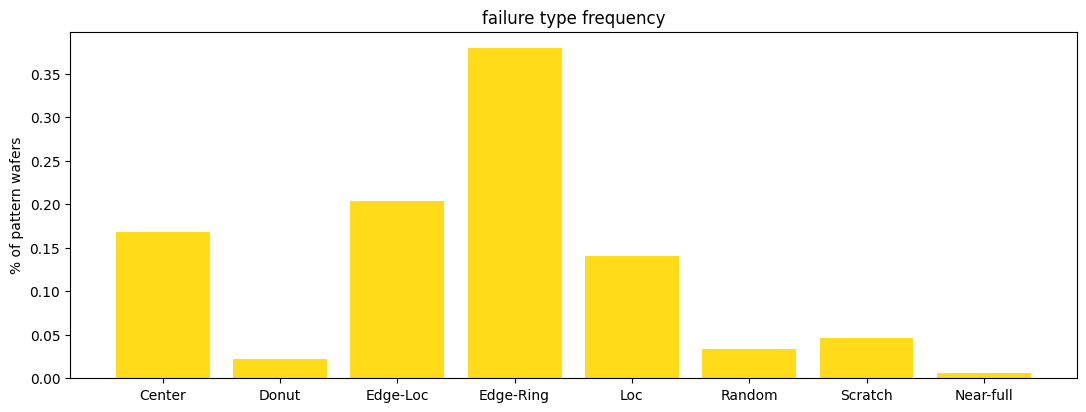

In [8]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 

ax2 = plt.subplot(gs[1])

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

웨이퍼 해상도 26 x 26 label로 웨이퍼 및 배열 (일부 웨이퍼 label은 null 생략)

In [9]:
sub_df = df.loc[df['waferMapDim'] == (25, 27)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x1 = sw[1:]
# 27 x 27 사이즈로 맞추기 위한 padding 처리
x = np.pad(x1, ((0,0),(1,1),(0,0)), mode='constant', constant_values = (0,0))
y = np.array(label).reshape((-1,1))

In [11]:
sub_df1 = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer1 = sub_df1['waferMap'].values

sw1 = np.ones((1, 26, 26))
label1 = list()

for i in range(len(sub_df1)):
    if len(sub_df1.iloc[i,:]['failureType']) == 0:
        continue
    sw1 = np.concatenate((sw1, sub_df1.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label1.append(sub_df1.iloc[i,:]['failureType'][0][0])

In [12]:
x2 = sw1[1:]
x3 = np.pad(x2, ((0,0),(1,0),(1,0)), mode='constant', constant_values = (0,0))
y2 = np.array(label1).reshape((-1,1))

In [13]:
sub_df2 = df.loc[df['waferMapDim'] == (27, 25)]
sub_wafer2 = sub_df2['waferMap'].values

sw2 = np.ones((1, 27, 25))
label2= list()

for i in range(len(sub_df2)):
    if len(sub_df2.iloc[i,:]['failureType']) == 0:
        continue
    sw2 = np.concatenate((sw2, sub_df2.iloc[i,:]['waferMap'].reshape(1, 27, 25)))
    label2.append(sub_df2.iloc[i,:]['failureType'][0][0])

In [14]:
x4 = sw2[1:]
x5 = np.pad(x4, ((0,0),(0,0),(1,1)), mode='constant', constant_values = (0,0))
y3 = np.array(label2).reshape((-1,1))

In [15]:
x3 = np.concatenate((x3, x5[0:]))
y2 = np.concatenate((y2, y3))

In [16]:
x = np.concatenate((x, x3[0:]))
y = np.concatenate((y, y2))

In [17]:
faulty_case = np.unique(y)

In [18]:
# '감지되지 않는' none 불량 라벨 제거
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [19]:
#train과 test 데이터를 8:2 비율로 맞춤
x_train_temp, x_test, y_train_temp, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=789)

In [20]:
#x_test : 채널 추가
x_test = x_test.reshape((-1, 27, 27, 1))

One-hot-Encoding

In [21]:
# One-hot-Encoding 
nx_test = np.zeros((len(x_test), 27, 27, 3))

for w in range(len(x_test)):
    for i in range(27):
        for j in range(27):
            nx_test[w, i, j, int(x_test[w, i, j])] = 1

In [22]:
#y_test : 문자열 데이터를 정수형으로 형변환
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
# one-hot-encoding - 10진 정수 형식을 2진 바이너리 형식으로 변경
y_test = to_categorical(y_test)

In [23]:
# One-hot-Encoding
nx_train = np.zeros((len(x_train_temp), 27, 27, 3))

for w in range(len(x_train_temp)):
    for i in range(27):
        for j in range(27):
            nx_train[w, i, j, int(x_train_temp[w, i, j])] = 1

Convolutional AutoEncoder

In [24]:
sx_train = np.delete(nx_train,(0,0,0,0), 1)

In [25]:
sx_train = np.delete(sx_train,(0,0,0,0), 2)

In [26]:
epoch = 50
batch_size=500

In [27]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D(padding='same')(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# decoder layers 연결
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

AutoEncoder = models.Model(input_tensor, output_tensor(decode))
AutoEncoder.compile(optimizer = 'Adam',
              loss = 'mse',
             ) 

In [28]:
AutoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [29]:
with tf.device('/GPU:0'):
    AutoEncoder.fit(sx_train, sx_train, batch_size=batch_size, epochs=epoch, verbose=2)

Epoch 1/50
31/31 - 8s - loss: 0.1290 - 8s/epoch - 269ms/step
Epoch 2/50
31/31 - 0s - loss: 0.0774 - 473ms/epoch - 15ms/step
Epoch 3/50
31/31 - 0s - loss: 0.0618 - 477ms/epoch - 15ms/step
Epoch 4/50
31/31 - 0s - loss: 0.0513 - 468ms/epoch - 15ms/step
Epoch 5/50
31/31 - 0s - loss: 0.0422 - 463ms/epoch - 15ms/step
Epoch 6/50
31/31 - 0s - loss: 0.0343 - 460ms/epoch - 15ms/step
Epoch 7/50
31/31 - 0s - loss: 0.0282 - 465ms/epoch - 15ms/step
Epoch 8/50
31/31 - 0s - loss: 0.0239 - 451ms/epoch - 15ms/step
Epoch 9/50
31/31 - 0s - loss: 0.0208 - 450ms/epoch - 15ms/step
Epoch 10/50
31/31 - 0s - loss: 0.0184 - 447ms/epoch - 14ms/step
Epoch 11/50
31/31 - 0s - loss: 0.0166 - 453ms/epoch - 15ms/step
Epoch 12/50
31/31 - 0s - loss: 0.0150 - 453ms/epoch - 15ms/step
Epoch 13/50
31/31 - 0s - loss: 0.0138 - 454ms/epoch - 15ms/step
Epoch 14/50
31/31 - 0s - loss: 0.0126 - 460ms/epoch - 15ms/step
Epoch 15/50
31/31 - 0s - loss: 0.0117 - 457ms/epoch - 15ms/step
Epoch 16/50
31/31 - 0s - loss: 0.0108 - 453ms/epoch

In [30]:
encoder = models.Model(input_tensor, latent_vector)

In [31]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [32]:
encoded_x = encoder.predict(sx_train)

471/471 [==============================] - 1s 1ms/step


In [33]:
sy_train_temp = np.array(y_train_temp)

In [34]:
# 웨이퍼 데이터 증강 수행
def gen_data(wafer, label):
    encoded_x = encoder.predict(wafer)
    
    # 노이즈 웨이퍼 수집 배열
    genn_x = np.zeros((1, 26, 26, 3))
    
    # 10000개의 증강 데이터 생성
    for i in range((10000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        genn_x = np.concatenate((genn_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(genn_x), 1), label)
    
    return genn_x[1:], gen_y[1:]

In [35]:
# 훈련 데이터셋 증강
for f in faulty_case : 
    if f == 'none': 
        continue
    genn_x, genn_y = gen_data(sx_train[np.where(y_train_temp==f)[0]], f)
    sx_train = np.concatenate((sx_train, genn_x), axis=0)
    sy_train_temp = np.concatenate((sy_train_temp, genn_y))

3/3 [==============================] - 0s 2ms/step


In [36]:
nsx_train = np.pad(sx_train, ((0,0),(1,0),(1,0),(0,0)), mode='constant', constant_values = (0,0))

In [37]:
for i, l in enumerate(faulty_case):
    sy_train_temp[sy_train_temp==l] = i
    
# one-hot-encoding
y_train = to_categorical(sy_train_temp)

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # AI 모델 평가를 위한 지표를 제공하는 scikit-learn의 metrics
    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [39]:
def VGG16(include_top=True,  pooling=None, classes=9):
    
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(1028, activation='relu', name='fc1')(x)
        x = layers.Dense(1028, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Create model
    model = models.Model(input_tensor, x, name='vgg16') 

    return model

In [40]:
VGG_model = VGG16(include_top=True, pooling=None, classes=9)

In [41]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 27, 27, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 27, 27, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 27, 27, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 13, 13, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 13, 13, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 13, 13, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 6, 6, 128)         0     

In [42]:
VGG_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [43]:
with tf.device('/GPU:0'):
    VGG_model_fit = VGG_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Epoch 1/50
109/109 [==============================] - 23s 153ms/step - loss: 1.5420 - accuracy: 0.3780 - val_loss: 1.4340 - val_accuracy: 0.1604
Epoch 2/50
109/109 [==============================] - 15s 135ms/step - loss: 0.3494 - accuracy: 0.8685 - val_loss: 0.2330 - val_accuracy: 0.9578
Epoch 3/50
109/109 [==============================] - 15s 135ms/step - loss: 0.0800 - accuracy: 0.9751 - val_loss: 0.1714 - val_accuracy: 0.9596
Epoch 4/50
109/109 [==============================] - 15s 135ms/step - loss: 0.0458 - accuracy: 0.9864 - val_loss: 0.1772 - val_accuracy: 0.9697
Epoch 5/50
109/109 [==============================] - 15s 136ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.2240 - val_accuracy: 0.9642
Epoch 6/50
109/109 [==============================] - 15s 136ms/step - loss: 0.0175 - accuracy: 0.9953 - val_loss: 0.1926 - val_accuracy: 0.9671
Epoch 7/50
109/109 [==============================] - 15s 135ms/step - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.1848 - val_ac

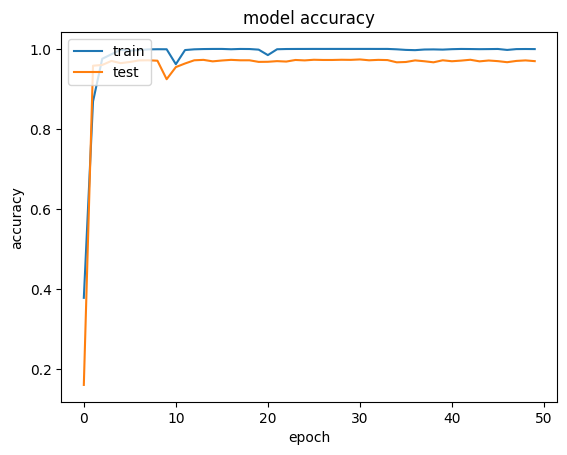

In [44]:
# accuracy plot 
plt.plot(VGG_model_fit.history['accuracy'])
plt.plot(VGG_model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

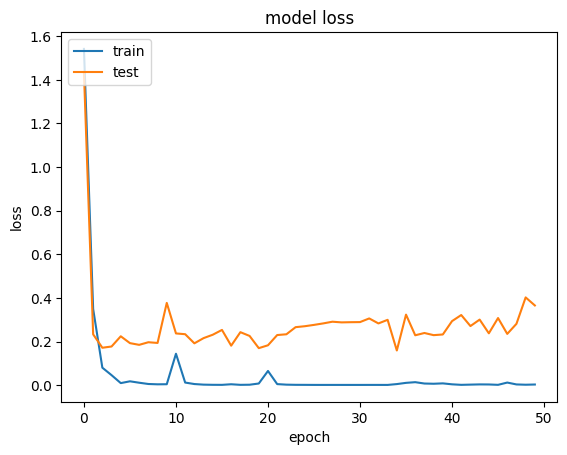

In [45]:
# loss plot
plt.plot(VGG_model_fit.history['loss'])
plt.plot(VGG_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
vy_pred = VGG_model.predict(nx_test)

118/118 [==============================] - 1s 7ms/step


In [47]:
vy_test_decode = np.ones(len(y_test))
vy_pred_decode = np.ones(len(vy_pred))

for i in range(len(vy_pred)):
    vy_pred_decode[i] = np.argmax(vy_pred[i])
    vy_test_decode[i] = np.argmax(y_test[i])

In [48]:
vmis_index = np.where(vy_pred_decode != vy_test_decode)

In [49]:
print(classification_report(vy_test_decode, vy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.97      0.98       475
       Donut       1.00      0.50      0.67         2
    Edge-Loc       0.89      0.81      0.85       166
   Edge-Ring       1.00      0.67      0.80         9
         Loc       0.83      0.63      0.72       106
   Near-full       1.00      0.79      0.88        14
      Random       0.84      0.90      0.87        30
     Scratch       1.00      0.29      0.44        21
        none       0.98      1.00      0.99      2943

    accuracy                           0.97      3766
   macro avg       0.95      0.73      0.80      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 460    0    0    0    2    0    0    0   13]
 [   0    1    0    0    1    0    0    0    0]
 [   1    0  135    0    7    0    1    0   22]
 [   0    0    3    6    0    0    0    0    0]
 [   3    0    9    0   67    0    1    0   26]
 [   0    0    1    0    0   11    2    0    0]
 [   0    0    1    0    1    0   27    0    1]
 [   0    0    0    0    1    0    1    6   13]
 [   1    0    3    0    2    0    0    0 2937]]
Normalized confusion matrix
[[9.68421053e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.21052632e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.73684211e-02]
 [0.00000000e+00 5.00000000e-01 0.00000000e+00 0.00000000e+00
  5.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [6.02409639e-03 0.00000000e+00 8.13253012e-01 0.00000000e+00
  4.21686747e-02 0.00000000e+00 6.02409639e-03 0.00000000e+00
  1.32530120e-01]
 [0.00000000e+00 0.00000000e+00 3.33333333e-01 6.66666667e-01
  0.0000000

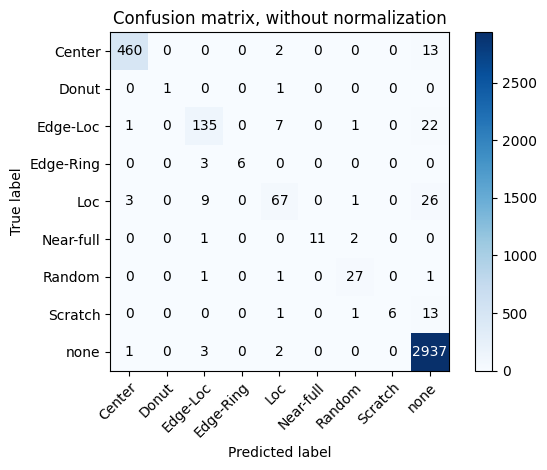

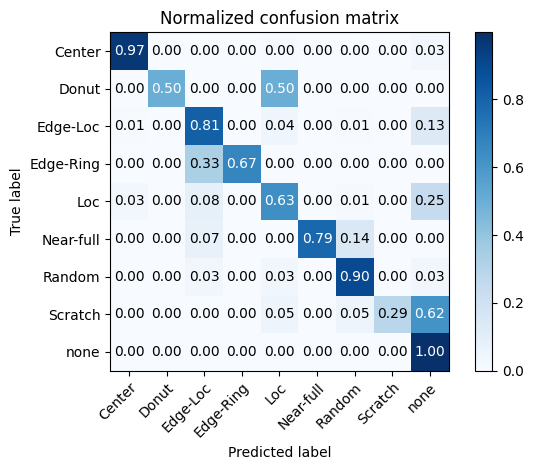

In [50]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [54]:
vgg_json_model = VGG_model.to_json()



VGG_model.save_weights("C:/mango/vgg16_model.h5")

In [ ]:
px_test = x_test[:,:,:,0]

In [ ]:
len(vmis_index[0])

150

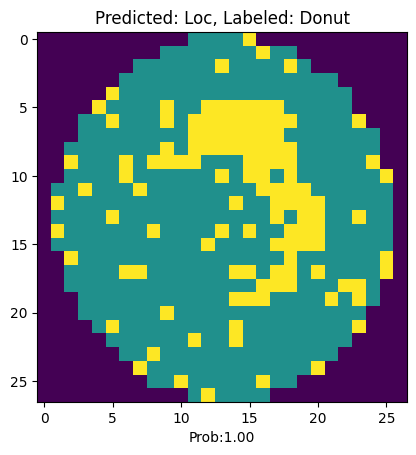

In [ ]:
for i in range (len(vmis_index[0])):
    if faulty_case[int(vy_test_decode[vmis_index[0][i]])] == 'Donut':
        # plot Donut fault data
        plt.imshow(px_test[vmis_index[0][i]])
        plt.title('Predicted: {}, Labeled: {}'.format(faulty_case[int(vy_pred_decode[vmis_index[0][i]])], faulty_case[int(vy_test_decode[vmis_index[0][i]])]) )
        plt.xlabel('Prob:{:.2f}'.format(vy_pred[vmis_index[0][i]][np.argmax(vy_pred[vmis_index[0][i]])]), fontsize=10)
        plt.show()

In [ ]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X


    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    
    # input_shpae 27 x 27 x 3
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # ResidualBlock 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # ResidualBlock 2 (≈3 layers)
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')
    
    # ResidualBlock 3 (≈4 layers)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # ResidualBlock 4 (≈6 layers)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # ResidualBlock 5 (≈3 layers)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
Rmodel = ResNet50(input_shape = (27, 27, 3), classes = 9)

In [ ]:
Rmodel.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 29, 29, 3)   0           ['input_4[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 27, 27, 64)   1792        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 27, 27, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [ ]:
Rmodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    Resnet_fit = Rmodel.fit(nsx_train, y_train, epochs=30, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Epoch 1/30
162/162 [==============================] - 34s 160ms/step - loss: 0.2411 - accuracy: 0.9187 - val_loss: 1.7657 - val_accuracy: 0.0921
Epoch 2/30
162/162 [==============================] - 23s 141ms/step - loss: 0.0238 - accuracy: 0.9924 - val_loss: 8.8087 - val_accuracy: 0.0736
Epoch 3/30
162/162 [==============================] - 23s 141ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 3.4812 - val_accuracy: 0.3704
Epoch 4/30
162/162 [==============================] - 23s 141ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.4154 - val_accuracy: 0.9464
Epoch 5/30
162/162 [==============================] - 23s 141ms/step - loss: 0.0104 - accuracy: 0.9968 - val_loss: 0.3985 - val_accuracy: 0.9501
Epoch 6/30
162/162 [==============================] - 23s 141ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.5551 - val_accuracy: 0.9336
Epoch 7/30
162/162 [==============================] - 23s 141ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.3978 - val_ac

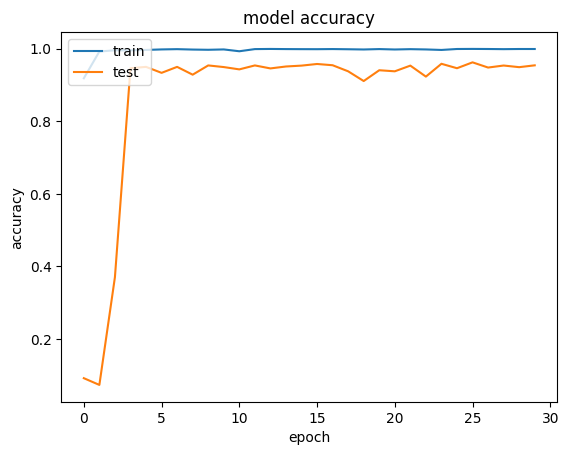

In [ ]:
# accuracy plot 
plt.plot(Resnet_fit.history['accuracy'])
plt.plot(Resnet_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

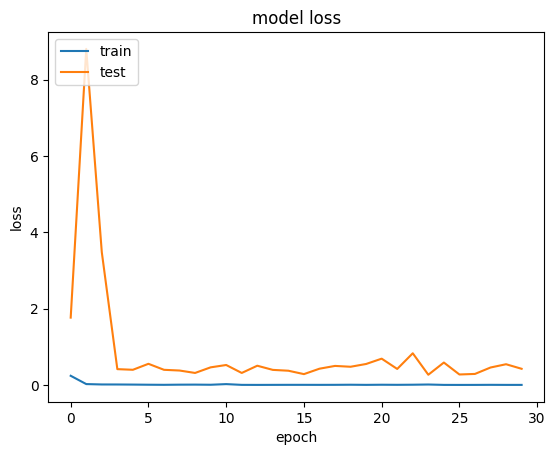

In [ ]:
# loss plot
plt.plot(Resnet_fit.history['loss'])
plt.plot(Resnet_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
resy_pred = Rmodel.predict(nx_test)

118/118 [==============================] - 3s 14ms/step


In [ ]:
resy_test_decode = np.ones(len(y_test))
resy_pred_decode = np.ones(len(resy_pred))

for i in range(len(resy_pred)):
    resy_pred_decode[i] = np.argmax(resy_pred[i])
    resy_test_decode[i] = np.argmax(y_test[i])

In [ ]:
resmis_index = np.where(resy_pred_decode != resy_test_decode)

In [ ]:
print(classification_report(resy_test_decode, resy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.97      0.98       462
       Donut       1.00      0.50      0.67         2
    Edge-Loc       0.92      0.60      0.73       152
   Edge-Ring       0.80      0.67      0.73         6
         Loc       0.78      0.56      0.65       131
   Near-full       0.60      0.50      0.55         6
      Random       0.92      0.71      0.80        34
     Scratch       1.00      0.14      0.24        22
        none       0.96      1.00      0.98      2951

    accuracy                           0.95      3766
   macro avg       0.89      0.63      0.70      3766
weighted avg       0.95      0.95      0.95      3766



Confusion matrix, without normalization
[[ 448    0    0    0    2    0    0    0   12]
 [   0    1    0    0    1    0    0    0    0]
 [   0    0   91    1    8    0    0    0   52]
 [   0    0    1    4    0    0    0    0    1]
 [   4    0    3    0   73    0    2    0   49]
 [   0    0    3    0    0    3    0    0    0]
 [   0    0    1    0    3    2   24    0    4]
 [   0    0    0    0    3    0    0    3   16]
 [   1    0    0    0    3    0    0    0 2947]]
Normalized confusion matrix
[[9.69696970e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.32900433e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.59740260e-02]
 [0.00000000e+00 5.00000000e-01 0.00000000e+00 0.00000000e+00
  5.00000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.98684211e-01 6.57894737e-03
  5.26315789e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.42105263e-01]
 [0.00000000e+00 0.00000000e+00 1.66666667e-01 6.66666667e-01
  0.0000000

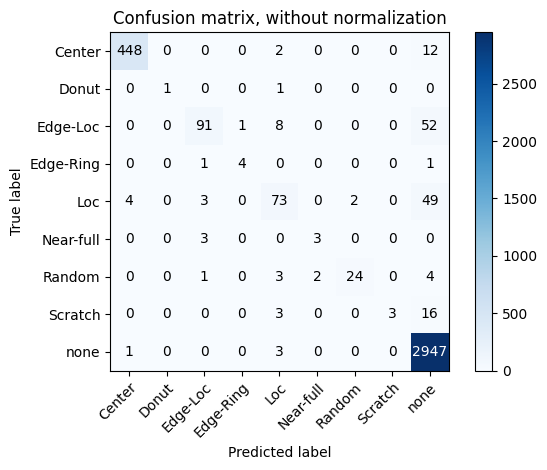

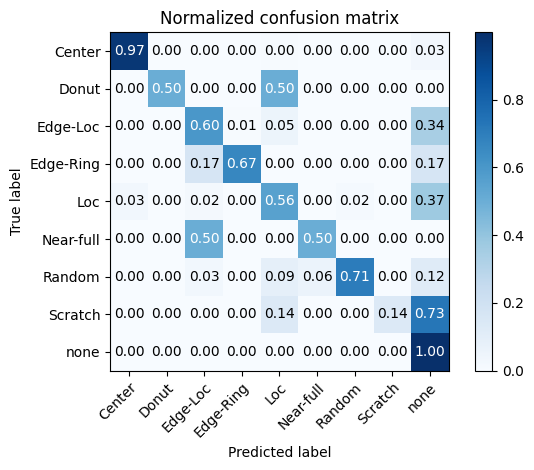

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [ ]:
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'strides', 'se_ratio'
])

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(3, 1, 32, 16, 1, [1, 1], 0.25),
    BlockArgs(3, 2, 16, 24, 6, [2, 2], 0.25),
    BlockArgs(5, 2, 24, 40, 6, [2, 2], 0.25),
    BlockArgs(3, 3, 40, 80, 6, [2, 2], 0.25),
    BlockArgs(5, 3, 80, 112,6, [1, 1], 0.25),
    BlockArgs(5, 4, 112, 192, 6, [2, 2], 0.25),
    BlockArgs(3, 1, 192, 320, 6, [1, 1], 0.25)
]

CONV_KERNEL_INITIALIZER = glorot_uniform(seed=0)

BN_AXIS = 3

In [ ]:
def get_swish():
    def swish(x):
        return x * tf.nn.sigmoid(x)
    return swish

In [ ]:
def get_dropout():
    """Wrapper over custom dropout. Fix problem of ``None`` shape for tf.keras.
    It is not possible to define FixedDropout class as global object,
    because we do not have modules for inheritance at first time.

    Issue:
        https://github.com/tensorflow/tensorflow/issues/30946
    """

    class FixedDropout(layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = tf.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout

In [ ]:
def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    
    # 원래 값이 x라면, 반올림후 값(y)은 x의 0.9 이상이어야 함
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

In [ ]:
def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

In [ ]:
def MBConvBlock(inputs, block_args, activation, drop_rate=None, prefix='', ):
    """
    Mobile Inverted Residual Bottleneck Block
    """
    
    # noise_shape에 none이 있으면 작동하지 않을 경우의 대비책
    Dropout = get_dropout()
    
    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    x = inputs
    
    # Expansion phase
    output = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = layers.Conv2D(output, 1,
                          padding='same',
                          use_bias=False, 
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'expand_conv')(x)
        x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'expand_bn')(x)
        x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
    
    # Depthwise convolution phase 
    x = layers.DepthwiseConv2D(block_args.kernel_size, 
                               strides=block_args.strides, 
                               padding='same',
                               use_bias=False, 
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=prefix + 'conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'bn')(x)
    x = layers.Activation(activation, name=prefix + 'activation')(x)
   
    # Squeeze and Excitation layer, if desired
    if has_se:
        num_sqeezed_channels = max(1, int(block_args.input_filters * block_args.se_ratio))
        
        se_tensor = layers.GlobalAveragePooling2D()(x)
        se_tensor = layers.Reshape((1,1,output), name=prefix + 'se_reshape')(se_tensor)
        se_tensor = layers.Conv2D(num_sqeezed_channels, 1, 
                          activation=activation, 
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'se_reduce')(se_tensor)
        se_tensor = layers.Conv2D(output, 1, 
                          activation='sigmoid', 
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'se_expand')(se_tensor)
        x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')
    
    #Output phase
    x = layers.Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'project_bn')(x)
    if all(s == 1 for s in block_args.strides) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = layers.add([x, inputs], name=prefix + 'add')
    
    return x

In [ ]:
def EfficientNet(width_coefficient,
                 depth_coefficient,
                 drop_connect_rate, 
                 input_shape,
                 classes,
                 dropout_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet'):
    
    input_tensor = layers.Input(input_shape)
    activation = get_swish()
    
    # Stem
    x = input_tensor
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2,2), 
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name='stem_bn')(x)
    x = layers.Activation(activation, name='stem_activation')(x)
    
    # Build blocks
    num_blocks_total = sum(round_repeats(block_args.num_repeat, depth_coefficient) for block_args in blocks_args)
    block_num = 0
    
    for idx, block_args in enumerate(blocks_args):
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters, width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters, width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))
        
        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        
        x = MBConvBlock(x, block_args,
                        activation=activation, 
                        drop_rate=drop_rate, 
                        prefix='block{}a_'.format(idx + 1))    
        block_num += 1
        
        if block_args.num_repeat > 1:
            block_args = block_args._replace(input_filters=block_args.output_filters, strides=[1, 1])
            for bidx in range(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(idx + 1, string.ascii_lowercase[bidx + 1])
                
                x = MBConvBlock(x, block_args,
                                activation=activation, 
                                drop_rate=drop_rate, 
                                prefix=block_prefix)
                block_num += 1
                
    # Build top
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name='top_bn')(x)
    x = layers.Activation(activation, name='top_activation')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    x = layers.Dense(classes, 
                     activation='softmax', 
                     kernel_initializer=CONV_KERNEL_INITIALIZER,
                     name='probs')(x)
    
    # 모델 생성
    model = models.Model(input_tensor, x, name=model_name)
    
    return model

In [ ]:
Emodel = EfficientNet(1.0, 1.0, 0.2, input_shape = (27, 27, 3), classes=9, model_name='efficientnet-b0')

In [ ]:
Emodel.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 14, 14, 32)   864         ['input_5[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 14, 14, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 14, 14, 32)   0           ['stem_bn[0][0]']                
                                                                                    

In [ ]:
Emodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    Emodel_fit = Emodel.fit(nsx_train, y_train, epochs=10, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Epoch 1/10
139/139 [==============================] - 63s 374ms/step - loss: 0.2948 - accuracy: 0.8950 - val_loss: 2.2417 - val_accuracy: 0.0382
Epoch 2/10
139/139 [==============================] - 48s 343ms/step - loss: 0.0368 - accuracy: 0.9889 - val_loss: 2.2977 - val_accuracy: 0.0382
Epoch 3/10
139/139 [==============================] - 48s 347ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 2.3257 - val_accuracy: 0.0382
Epoch 4/10
139/139 [==============================] - 48s 344ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 2.1590 - val_accuracy: 0.0465
Epoch 5/10
139/139 [==============================] - 48s 343ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.2070 - val_accuracy: 0.9466
Epoch 6/10
139/139 [==============================] - 48s 343ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.3550 - val_accuracy: 0.9517
Epoch 7/10
139/139 [==============================] - 48s 344ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.3769 - val_ac

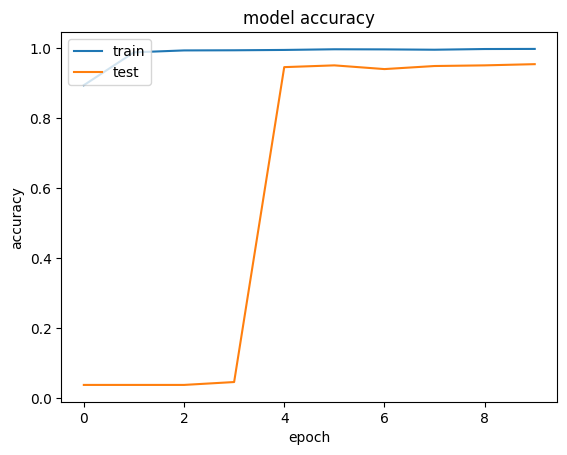

In [ ]:
# accuracy plot 
plt.plot(Emodel_fit.history['accuracy'])
plt.plot(Emodel_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

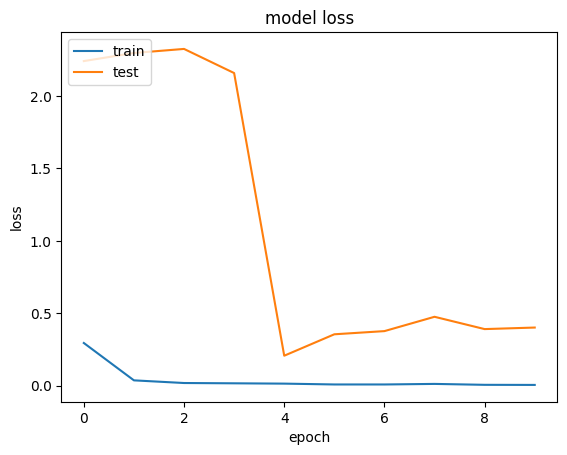

In [ ]:
# loss plot
plt.plot(Emodel_fit.history['loss'])
plt.plot(Emodel_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
effy_pred = Emodel.predict(nx_test)

118/118 [==============================] - 3s 16ms/step


In [ ]:
effy_test_decode = np.ones(len(y_test))
effy_pred_decode = np.ones(len(effy_pred))

for i in range(len(resy_pred)):
    effy_pred_decode[i] = np.argmax(effy_pred[i])
    effy_test_decode[i] = np.argmax(y_test[i])

In [ ]:
effmis_index = np.where(effy_pred_decode != effy_test_decode)

In [ ]:
print(classification_report(effy_test_decode, effy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.98      0.98       459
       Donut       0.00      0.00      0.00         3
    Edge-Loc       0.80      0.73      0.76       144
   Edge-Ring       0.67      0.55      0.60        11
         Loc       0.70      0.46      0.55       114
   Near-full       0.92      1.00      0.96        11
      Random       0.93      0.76      0.84        34
     Scratch       1.00      0.09      0.17        22
        none       0.96      0.99      0.98      2968

    accuracy                           0.96      3766
   macro avg       0.77      0.62      0.65      3766
weighted avg       0.95      0.96      0.95      3766



Confusion matrix, without normalization
[[ 450    0    0    0    0    0    0    0    9]
 [   0    0    0    0    2    0    1    0    0]
 [   0    0  105    3    8    0    1    0   27]
 [   0    0    4    6    0    0    0    0    1]
 [   2    0    9    0   52    0    0    0   51]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    3    0    3    1   26    0    1]
 [   0    0    0    0    2    0    0    2   18]
 [   5    0   11    0    7    0    0    0 2945]]
Normalized confusion matrix
[[0.98039216 0.         0.         0.         0.         0.
  0.         0.         0.01960784]
 [0.         0.         0.         0.         0.66666667 0.
  0.33333333 0.         0.        ]
 [0.         0.         0.72916667 0.02083333 0.05555556 0.
  0.00694444 0.         0.1875    ]
 [0.         0.         0.36363636 0.54545455 0.         0.
  0.         0.         0.09090909]
 [0.01754386 0.         0.07894737 0.         0.45614035 0.
  0.         0.         0.44736842]
 [0.         0.    

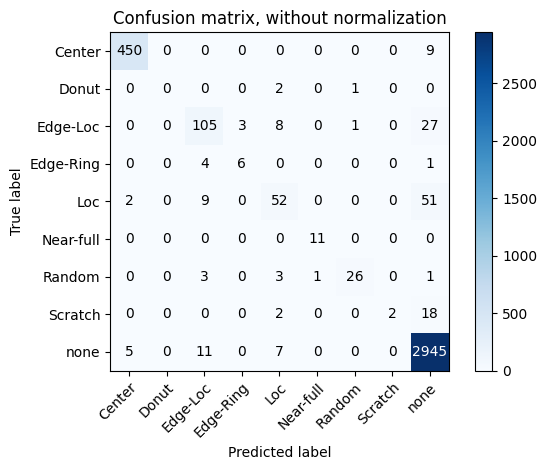

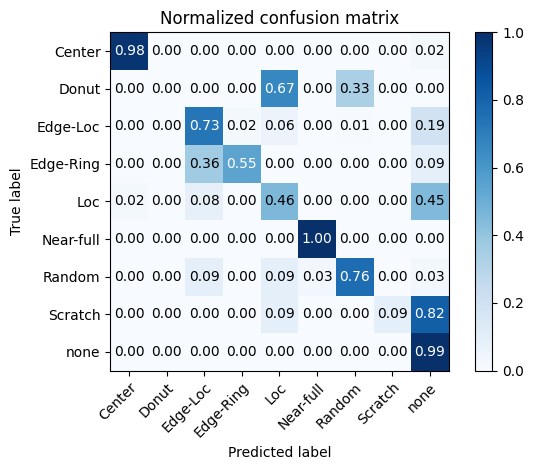

In [ ]:
plot_confusion_matrix(effy_test_decode, effy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

plot_confusion_matrix(effy_test_decode, effy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [ ]:
last_conv_layer = Rmodel.get_layer("activation_48")

model_1 = models.Model(Rmodel.inputs, last_conv_layer.output)

In [ ]:
input_2 = layers.Input(shape=last_conv_layer.output.shape[1:])
x_2 = Rmodel.get_layer("flatten")(input_2)
model_2 = models.Model(input_2, x_2)

In [ ]:
with tf.GradientTape() as tape:
    output_1 = model_1(nx_test)
    tape.watch(output_1)
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]
    
grads = tape.gradient(output_1, output_1)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

ResourceExhaustedError: Exception encountered when calling layer "res2a_branch2c" "                 f"(type Conv2D).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3766,13,13,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BiasAdd]

Call arguments received by layer "res2a_branch2c" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(3766, 13, 13, 32), dtype=float32)